### GOES and AIA flare catalog production - Goal 2
This notebook contains some sample code to load up the AIA flare catalog and the GOES flare catalog and extract the GOES M/X flares which are not captured in the AIA flare catalog. There is an outline of steps you might take to investigate these events.

In [1]:
## import packages
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
from datetime import datetime,timedelta
from helper import *
import warnings
warnings.filterwarnings("ignore")


In [24]:
## load the AIA flare catalog 
flares = pd.read_csv('flare_catalogs/aia_flares_catalog_7_pred.csv')
goes_catalog = pd.read_csv('flare_catalogs/goes_catalog_with_noaa_ar2.csv',na_values=' ')
goes_catalog = goes_catalog.dropna(subset=['SHARP'])
goes_catalog = goes_catalog[pd.to_numeric(goes_catalog['SHARP'])>=20]
goes_catalog.SHARP = pd.to_numeric(goes_catalog['SHARP']).astype('int64')

bhs = pd.read_csv('sharps_badheaders.csv')
bhs = [x[0] for x in bhs.values]
goes_catalog = goes_catalog[~goes_catalog.SHARP.isin(bhs)]

outofrange = pd.read_csv('flares_with_limbs2.csv')
outofrange = [x[0] for x in outofrange.values]
goes_catalog = goes_catalog.drop(outofrange,errors='ignore')

nes_noaa = pd.read_csv('nonempty_sharps_with_noaa_ar.csv')
goes_catalog = goes_catalog[goes_catalog.SHARP.isin(nes_noaa.HARPNUM)]
goes_catalog = goes_catalog.reset_index().rename(columns={'index':'flare_ind'})

goes_MX = goes_catalog[np.logical_or(goes_catalog['CMX']=='X',goes_catalog['CMX']=='M')]
lams = ['193','171','304','1600','131','94']


# filter only GOES events not found in AIA catalog
flares_noaia = goes_MX[~goes_MX['flare_ind'].isin(flares['goes_flare_ind'])]
print(len(flares_noaia),'flares missing in the AIA catalog with GOES M/X labels')
print(flares_noaia.iloc[20:])


32 flares missing in the AIA catalog with GOES M/X labels
      flare_ind    DATE  START_TIME  END_TIME MAX_TIME   LOCATION CMX  \
3853       5516  150209        2219        16     2335  S08W33      M   
3874       5545  150303         125       142      135  N21W87      M   
3912       5587  150311         710       743      718  S16E26      M   
3951       5626  150317        2249      2348     2334  N10W54      M   
4006       5721  150422         830       858      844  S09E05      M   
4297       6111  150917         934       945      940  S21W04      M   
4537       6432  160215        1041      1106     1100  S20W48      M   
4673       6597  160807        1437      1448     1444  N09W67      M   
4904       6917  170904        1959      2006      NaN        NaN   M   
4911       6924  170905         633       643      NaN        NaN   M   
4937       6950  170907        2350        14      NaN        NaN   M   
4944       6989  170910        1535      1631      NaN        NaN 

In [5]:
aia_dir = '/srv/data/sdo_sharps/aia_timeseries/' # might need to change this to the path to the aia timeseries data

In [ ]:
## loop through the catalog and plot event
i=0
# for i in range(len(flares_goes)):
flare = flares_noaia.iloc[i]
flare['mean_start_time'] = pd.to_datetime('20' + flare['DATE'].astype('str') + '_' + 
                                flare['START_TIME'].astype('str').zfill(4) + '00', format='%Y%m%d_%H%M%S')
flare['mean_end_time'] = pd.to_datetime('20' + flare['DATE'].astype('str') + '_' + 
                                flare['END_TIME'].astype('str').zfill(4) + '00', format='%Y%m%d_%H%M%S')
if flare['mean_end_time']<flare['mean_start_time']:
    flare['mean_end_time']=flare['mean_end_time']+timedelta(days=1)
    
# load AIA timeseries data 
with open(aia_dir+'sharp_'+str(flare['SHARP'])+'_aia_sum_intensity', "rb") as fp:   #Pickling
    aia_data = pickle.load(fp)
with open(aia_dir+'sharp_'+str(flare['SHARP'])+'_aia_times', "rb") as fp:   #Pickling
    aia_times = pickle.load(fp)

plot_flare_goes(flare,aia_times,aia_data,window=60)
# break

If the figure contains a distinct peak near the blue window (ie. i=1), it's probably listed in the AIA catalog but with errors so it isn't associated to the GOES peak. You'll have to look through the AIA catalog at entries with the given SHARP number and the given date/times. You can manually correct anything which doesn't look correct and associate it with the GOES peak. 

If there isn't a distinct peak (ie. i=13), we'll need to do some investigating. You can check solar monitor for this date and the corresponding flare and active region. Check if the flare is in the database and what AR is associated with it, then cross reference with the AR-SHARP list.

In [ ]:
print(flare)

start: 2014-01-04 22:12:00 , end: 2014-01-04 23:22:00


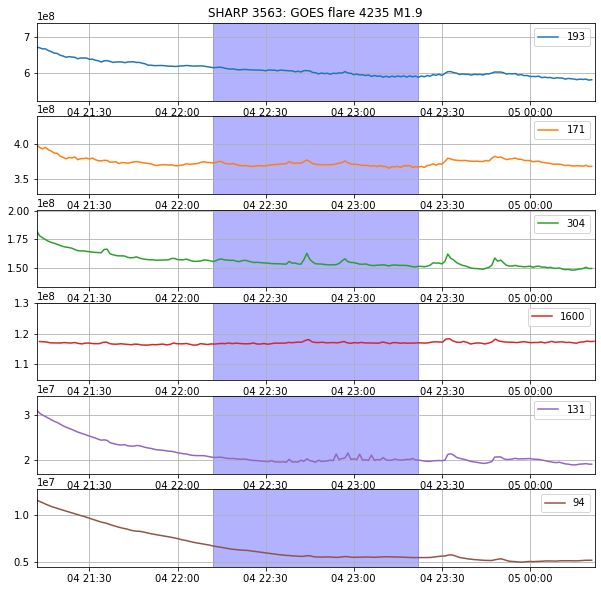

In [23]:
## loop through the catalog and plot event
for i in [3100]:
    flare = flares_noaia.loc[i]
    flare['mean_start_time'] = pd.to_datetime('20' + flare['DATE'].astype('str') + '_' + 
                                flare['START_TIME'].astype('str').zfill(4) + '00', format='%Y%m%d_%H%M%S')
    flare['mean_end_time'] = pd.to_datetime('20' + flare['DATE'].astype('str') + '_' + 
                                flare['END_TIME'].astype('str').zfill(4) + '00', format='%Y%m%d_%H%M%S')
    if flare['mean_end_time']<flare['mean_start_time']:
        flare['mean_end_time']=flare['mean_end_time']+timedelta(days=1)
    
# load AIA timeseries data 
    with open(aia_dir+'sharp_'+str(flare['SHARP'])+'_aia_sum_intensity', "rb") as fp:   #Pickling
        aia_data = pickle.load(fp)
    with open(aia_dir+'sharp_'+str(flare['SHARP'])+'_aia_times', "rb") as fp:   #Pickling
        aia_times = pickle.load(fp)

    plot_flare_goes(flare,aia_times,aia_data,window=60)
    output_filename = f'Unlabeled_Plots/plot-{i}.png'
    # plt.savefig(output_filename,facecolor='white') #save figures to directory
    # plt.close('all')


# for i in range(28,32):
#     flare = flares_noaia.iloc[i]
#     flare['mean_start_time'] = pd.to_datetime('20' + flare['DATE'].astype('str') + '_' + 
#                                 flare['START_TIME'].astype('str').zfill(4) + '00', format='%Y%m%d_%H%M%S')
#     flare['mean_end_time'] = pd.to_datetime('20' + flare['DATE'].astype('str') + '_' + 
#                                 flare['END_TIME'].astype('str').zfill(4) + '00', format='%Y%m%d_%H%M%S')
#     if flare['mean_end_time']<flare['mean_start_time']:
#         flare['mean_end_time']=flare['mean_end_time']+timedelta(days=1)
    
# # load AIA timeseries data 
#     with open(aia_dir+'sharp_'+str(flare['SHARP'])+'_aia_sum_intensity', "rb") as fp:   #Pickling
#         aia_data = pickle.load(fp)
#     with open(aia_dir+'sharp_'+str(flare['SHARP'])+'_aia_times', "rb") as fp:   #Pickling
#         aia_times = pickle.load(fp)

#     plot_flare_goes(flare,aia_times,aia_data,window=60)
#     output_filename = f'Unlabeled_Plots/plot-{i}.png'
#     plt.savefig(output_filename,facecolor='white') #save figures to directory
#     plt.close('all')

In [6]:
flare

flare_ind                         6597
DATE                            160807
START_TIME                        1437
END_TIME                          1448
MAX_TIME                          1444
LOCATION                     N09W67   
CMX                                  M
CMX_VALUE                           13
INTENSITY                      0.00013
FLUX                            0.0046
AR                               12572
SHARP                             6688
mean_start_time    2016-08-07 14:37:00
mean_end_time      2016-08-07 14:48:00
Name: 4673, dtype: object